# 00__calculate_cage_exp_and_ts
# calculating CAGE expression and tissue-specificity from FANTOM5 files

in this notebook, i parse FANTOM5 files and calculate CAGE expression & tissue specificities. i use the groups outlined in Supplemental Table S7 to group samples by sample type and omit ambiguous samples, and then calculate average expression across these groups. i also calculate tissue specificity across these groups and assign TSSs to be either "ubiquitous" (expressed in >50% of groups), "dynamic" (expressed in <50% of groups, but expressed at >50tpm in at least 1 group), or "tissue-specific" (expressed in <50% of groups, and never above 50tpm in any group).

i also get a list of 'robust' enhancers using the same criteria defined by fantom5 for the 'robust' TSSs: A ‘robust’ threshold, for which a peak must include a CTSS with more than 10 read counts and 1 TPM (tags per million) at least one sample, was employed to define a stringent subset of the CAGE peaks (from [here](https://www.nature.com/articles/sdata2017112))

------

no figures in this notebook

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.bed"

In [4]:
tss_cage_exp_f = "../../misc/01__cage/TSS.CAGE_grouped_exp.tissue_sp.txt.gz"
enh_cage_exp_f = "../../misc/01__cage/Enh.CAGE_grouped_exp.tissue_sp.txt.gz"

In [5]:
robust_enh_f = "../../misc/01__cage/human_robust_enhancers.txt"

## 1. import data

In [6]:
all_tss = pd.read_table(all_tss_f, sep="\t", header=None)
all_tss.columns = ["chr", "start", "end", "name", "score", "strand"]
all_tss.head()

,chr,start,end,name,score,strand
0,chr1,10003350,10003465,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-
1,chr1,10003452,10003567,protein_coding__p1@NMNAT1__chr1:10003486..1000...,0,+
2,chr1,100111588,100111703,protein_coding__p1@PALMD__chr1:100111580..1001...,0,+
3,chr1,100232148,100232263,protein_coding__p1@FRRS1__chr1:100232177..1002...,0,-
4,chr1,100315601,100315716,protein_coding__p1@AGL__chr1:100315613..100315...,0,+


In [7]:
tss_cage_exp = pd.read_table(tss_cage_exp_f, sep="\t")
tss_cage_exp.head()

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,"chr10:100013403..100013414,-","p@chr10:100013403..100013414,-",0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667
1,"chr10:100027943..100027958,-",p1@LOXL4,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,...,0.0,0.000000,0.0,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667
2,"chr10:100076685..100076699,+","p@chr10:100076685..100076699,+",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN
3,"chr10:100150910..100150935,-","p@chr10:100150910..100150935,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.548168,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN
4,"chr10:100150951..100150962,-","p@chr10:100150951..100150962,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,1.096335,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN


In [8]:
tss_cage_exp[tss_cage_exp["00Annotation"] == "chr20:49575059..49575077,-"]

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
102061,"chr20:49575059..49575077,-",p1@DPM1,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,...,101.771054,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991


In [9]:
tss_cage_exp["cage_id"] = tss_cage_exp["00Annotation"]
tss_cage_exp.drop(["00Annotation", "short_description"], axis=1, inplace=True)

In [10]:
enh_cage_exp = pd.read_table(enh_cage_exp_f, sep="\t")
enh_cage_exp.head()

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,chr1:839741-840250,0.0,0.216714,0.0,0.0,0.000000,0.102923,0.000000,0.0,0.0,...,0.0,0.00000,0.306431,0.206949,0.0,0.38338,0.087482,0.110784,0.981674,0.483654
1,chr1:840753-841210,0.0,0.216714,0.0,0.0,0.000000,0.000000,0.543603,0.0,0.0,...,0.0,0.13168,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.984912,0.483654
2,chr1:845485-845678,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.181201,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990033,0.666667
3,chr1:855764-856157,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990598,0.666667
4,chr1:856539-856757,0.0,0.000000,0.0,0.0,0.199924,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.087482,0.000000,0.977400,0.479531


In [11]:
enh_cage_exp["cage_id"] = enh_cage_exp["Id"]
enh_cage_exp.drop(["Id"], axis=1, inplace=True)

In [12]:
robust_enh = pd.read_table(robust_enh_f, sep="\t", skiprows=1, header=None)
robust_enh.columns = ["cage_id"]
robust_enh.head()

,cage_id
0,chr10:100074404-100074582
1,chr10:100076038-100076149
2,chr10:100076500-100076699
3,chr10:100082942-100083374
4,chr10:100120877-100121283


In [13]:
# limit enhancers to robust only!
enh_cage_exp = enh_cage_exp[enh_cage_exp["cage_id"].isin(robust_enh["cage_id"])]
len(enh_cage_exp)

36906

In [14]:
all_cage_exp = tss_cage_exp.append(enh_cage_exp)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
37481,0.000,0.000000,0.000000,0.000000,0.000000,2.323207,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.310439,0.223711,0.000000,0.000000,0.000000,0.113942,0.984517,NaN,"chr14:28910171..28910172,+"
46566,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998182,NaN,"chr15:76104386..76104393,+"
27920,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.989770,NaN,chr18:74179507-74179930
18835,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196291,0.000000,...,0.131680,0.000000,0.000000,0.000000,0.383380,0.000000,0.000000,0.986394,0.666667,chr14:92451454-92451633
98247,0.543,1.558322,2.329919,0.999937,1.481715,0.422401,1.122843,2.957676,1.265988,2.949275,...,2.192671,3.603708,0.894843,2.405134,0.800056,1.887235,0.911536,0.868039,0.426507,"chr20:10414793..10414803,-"


In [15]:
all_cage_exp[all_cage_exp["cage_id"] == "chr20:49575059..49575077,-"]

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
102061,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,89.674177,79.138877,...,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991,"chr20:49575059..49575077,-"


## 2. parse CAGE IDs

In [16]:
def get_cage_id(row):
    if "Enhancer" in row["name"]:
        return row["name"].split("__")[1]
    else:
        return row["name"].split("__")[2]

In [17]:
all_tss["cage_id"] = all_tss.apply(get_cage_id, axis=1)
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id
49486,chr5,82339315,82339430,Enhancer__chr5:82339174-82339396,0,+,chr5:82339174-82339396
23154,chr7,128828393,128828508,protein_coding__p1@SMO__chr7:128828464..128828...,0,+,"chr7:128828464..128828486,+"
54066,chr8,138127930,138128045,Enhancer__chr8:138127767-138128050,0,+,chr8:138127767-138128050
36949,chr16,24538613,24538728,Enhancer__chr16:24538501-24538703,0,+,chr16:24538501-24538703
446,chr1,151254364,151254479,"protein_coding__NA__chr1:151254393..151254430,-",0,-,"chr1:151254393..151254430,-"


## 3. get av exp & t.s. across all samples

In [18]:
samples = [x for x in all_cage_exp.columns if "Group_" in x]
all_cage_exp["av_exp"] = all_cage_exp[samples].mean(axis=1)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp
157039,0.0,0.222617,1.164959,0.000000,0.423347,4.118413,0.000000,0.000000,0.421996,9.585143,...,2.620879,1.342265,0.801711,0.000000,1.527762,0.113942,0.973147,0.427761,"chr6:10528595..10528622,+",0.809341
57077,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992790,0.587411,chr7:116483555-116483740,0.018243
110845,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996287,NaN,"chr2:11251855..11251865,-",0.035959
142656,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998090,NaN,"chr4:20393774..20393779,+",0.006410
150969,0.0,0.111309,1.164959,0.199987,1.481715,0.211201,0.935703,0.203978,0.000000,0.000000,...,0.000000,0.000000,0.801711,0.800056,0.269605,0.569710,0.925210,0.289783,"chr5:153825346..153825365,-",0.537327


## 4. merge

In [19]:
all_tss[all_tss["cage_id"] == "chr20:49575059..49575077,-"]

,chr,start,end,name,score,strand,cage_id


In [20]:
all_tss = all_tss.merge(all_cage_exp[["cage_id", "av_exp", "tissue_sp_all"]], on="cage_id")
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all
31422,chr6,106008760,106008875,Enhancer__chr6:106008502-106008841,0,+,chr6:106008502-106008841,0.020739,0.991803
1242,chr1,28286429,28286544,"div_pc__p1@XKR8__chr1:28286476..28286549,+",0,+,"chr1:28286476..28286549,+",5.004401,0.965118
14696,chr6,36410596,36410711,protein_coding__p1@PXT1__chr6:36410620..364106...,0,-,"chr6:36410620..36410636,-",0.207077,0.990311
15820,chr8,100025222,100025337,div_lnc__p1@ENST00000521696__chr8:100025238..1...,0,-,"chr8:100025238..100025266,-",4.087736,0.854248
6913,chr17,34344974,34345089,protein_coding__p1@CCL23__chr17:34345002..3434...,0,-,"chr17:34345002..34345016,-",0.269255,0.986936


## 5. define promtype2

In [21]:
all_tss["PromType2"] = all_tss["name"].str.split("__", expand=True)[0]
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all,PromType2
27184,chr2,69084484,69084599,Enhancer__chr2:69084387-69084602,0,+,chr2:69084387-69084602,0.197448,0.996722,Enhancer
12622,chr4,140223587,140223702,protein_coding__p2@NDUFC1__chr4:140223614..140...,0,-,"chr4:140223614..140223668,-",7.471996,0.880139,protein_coding
31487,chr6,109100920,109101035,Enhancer__chr6:109100819-109101213,0,+,chr6:109100819-109101213,0.174862,0.990637,Enhancer
22095,chr12,96819315,96819430,Enhancer__chr12:96819131-96819446,0,+,chr12:96819131-96819446,0.154558,0.974516,Enhancer
2513,chr10,99258602,99258717,protein_coding__p1@UBTD1__chr10:99258637..9925...,0,+,"chr10:99258637..99258751,+",14.720035,0.880879,protein_coding


In [22]:
all_tss.PromType2.unique()

array(['div_pc', 'protein_coding', 'div_lnc', 'antisense', 'intergenic',
       'Enhancer'], dtype=object)

## 5. plot

In [23]:
all_tss["log_av_exp"] = np.log(all_tss["av_exp"]+1)

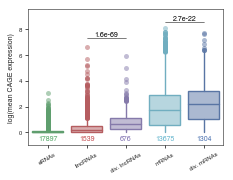

In [27]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="log_av_exp", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
enhs = np.asarray(all_tss[all_tss["PromType2"] == "Enhancer"]["log_av_exp"])
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["log_av_exp"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["log_av_exp"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["log_av_exp"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["log_av_exp"])

enhs = enhs[~np.isnan(enhs)]
lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)

annotate_pval(ax, 1, 2, 7.3, 0, 0, lnc_pval, fontsize, False, None, None)
annotate_pval(ax, 3, 4, 8.5, 0, 0, pc_pval, fontsize, False, None, None)

plt.ylim((-1, 9.5))
plt.xlabel("")
plt.ylabel("log(mean CAGE expression)")

x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
x_ax_diff = x_ax_1 - x_ax_0

ax.annotate(str(len(enhs)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["Enhancer"], size=fontsize)
ax.annotate(str(len(lincs)), xy=(x_ax_0+(x_ax_diff*1), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["intergenic"], size=fontsize)
ax.annotate(str(len(div_lncs)), xy=(x_ax_0+(x_ax_diff*2), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["div_lnc"], size=fontsize)
ax.annotate(str(len(pcs)), xy=(x_ax_0+(x_ax_diff*3), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["protein_coding"], size=fontsize)
ax.annotate(str(len(div_pcs)), xy=(x_ax_0+(x_ax_diff*4), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["div_pc"], size=fontsize)
    

fig.savefig("cage_exp_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [28]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 1.57929015786e-69
pc pval: 2.66992847149e-22


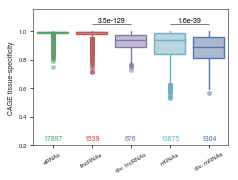

In [29]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="tissue_sp_all", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
enhs = np.asarray(all_tss[all_tss["PromType2"] == "Enhancer"]["tissue_sp_all"])
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["tissue_sp_all"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["tissue_sp_all"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["tissue_sp_all"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["tissue_sp_all"])

enhs = enhs[~np.isnan(enhs)]
lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)
    
annotate_pval(ax, 1, 2, 1.05, 0, 0, lnc_pval, fontsize, False, None, None)
annotate_pval(ax, 3, 4, 1.05, 0, 0, pc_pval, fontsize, False, None, None)

x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
x_ax_diff = x_ax_1 - x_ax_0

ax.annotate(str(len(enhs)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["Enhancer"], size=fontsize)
ax.annotate(str(len(lincs)), xy=(x_ax_0+(x_ax_diff*1), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["intergenic"], size=fontsize)
ax.annotate(str(len(div_lncs)), xy=(x_ax_0+(x_ax_diff*2), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["div_lnc"], size=fontsize)
ax.annotate(str(len(pcs)), xy=(x_ax_0+(x_ax_diff*3), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["protein_coding"], size=fontsize)
ax.annotate(str(len(div_pcs)), xy=(x_ax_0+(x_ax_diff*4), 0.02), xycoords="axes fraction", xytext=(0, 0), 
            textcoords="offset pixels", ha='center', va='bottom', 
            color=TSS_CLASS_PALETTE["div_pc"], size=fontsize)

plt.ylim((0.2, 1.15))
plt.xlabel("")
plt.ylabel("CAGE tissue-specificity")
fig.savefig("cage_ts_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [30]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 3.52167111424e-129
pc pval: 1.60610483516e-39


## define promoters as "ubiquitous" v "tissue-specific"
ubiquitous = on in >50% of samples
dynamic = on in < 50% of samples, in at least 1 sample on at > 10
tissue-sp = on in < 50% of samples

In [31]:
all_cage_exp["n_expr"] = all_cage_exp[samples].astype(bool).sum(axis=1)
all_cage_exp.head()

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr
0,0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667,"chr10:100013403..100013414,-",0.023403,38
1,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,0.000000,0.0,...,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667,"chr10:100027943..100027958,-",5.375834,346
2,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.210998,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN,"chr10:100076685..100076699,+",0.012479,34
3,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN,"chr10:100150910..100150935,-",0.155925,80
4,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN,"chr10:100150951..100150962,-",0.038083,49


In [32]:
len(all_cage_exp)

238369

In [33]:
def expr_type(row, samples, thresh):
    if row.n_expr > 0.9*len(samples):
        return "ubiquitous"
    elif row.n_expr < 0.1*len(samples):
        exprs = list(row[samples])
        over_thresh = any(i >= thresh for i in exprs)
        if over_thresh > 0:
            return "dynamic"
        else:
            return "tissue-specific"
    else:
        return "moderate"

all_cage_exp["tss_type"] = all_cage_exp.apply(expr_type, axis=1, samples=samples, thresh=50)
all_cage_exp.sample(10)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr,tss_type
24790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.630809,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.087482,0.000000,0.988096,0.666667,chr17:39807728-39808143,0.210833,149,moderate
167855,0.000000,0.000000,1.164959,0.000000,0.000000,0.000000,0.000000,0.101989,0.000000,0.000000,...,0.000000,0.000000,0.089868,0.000000,0.992003,NaN,"chr6:84222196..84222218,+",0.491577,210,moderate
23259,0.000000,0.000000,0.000000,0.000000,0.000000,0.102923,0.000000,0.098692,0.392582,0.000000,...,0.000000,0.000000,0.000000,0.110784,0.985812,0.355658,chr16:84784930-84785133,0.035897,83,moderate
16494,2.171998,0.445235,0.000000,0.199987,0.000000,0.633602,0.000000,0.000000,0.210998,0.000000,...,0.000000,0.800056,0.000000,0.455768,0.925695,0.666667,"chr11:6440624..6440669,-",1.151886,377,moderate
56571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.989463,NaN,chr7:92592095-92592395,0.026659,44,tissue-specific
127562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.981852,NaN,"chr3:115529191..115529209,-",0.122211,112,moderate
139119,28.778979,38.846738,20.969271,1.199924,9.736985,28.300890,17.216930,18.663956,8.650921,2.211956,...,19.241073,7.600528,21.927878,16.977366,0.911290,0.222040,"chr4:120133857..120133881,+",18.348845,540,ubiquitous
17670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181201,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.981256,0.666667,chr14:50429310-50429592,0.025963,58,moderate
130461,45.611967,113.200953,43.103501,33.197908,20.744011,5.913619,6.362778,10.504849,9.705911,79.630422,...,105.024189,6.800472,14.199199,15.724004,0.887362,0.467306,"chr3:15374033..15374107,-",41.969787,546,ubiquitous
1554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.993597,NaN,"chr10:119004120..119004149,+",0.004331,6,tissue-specific


In [34]:
all_cage_exp.tss_type.value_counts()

moderate           130287
tissue-specific     83651
ubiquitous          20304
dynamic              4127
Name: tss_type, dtype: int64

## write file

In [35]:
final = all_cage_exp[["cage_id", "av_exp", "tissue_sp_all",  "tissue_sp_3", "n_expr", "tss_type"]]
final.sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
31247,chr2:42952930-42953056,0.025746,0.985819,NaN,64,moderate
7879,chr10:75648556-75649146,0.295235,0.982122,0.666667,212,moderate
9630,"chr11:111649083..111649123,-",0.082268,0.996460,0.666667,14,tissue-specific
27341,"chr12:57824836..57824847,-",0.422922,0.909241,0.356228,391,moderate
22113,"chr12:122186264..122186278,+",0.155206,0.973996,0.427420,128,moderate


In [36]:
final[final["tss_type"] == "dynamic"].sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
133617,"chr3:23790537..23790554,+",0.538334,0.996207,NaN,44,dynamic
103727,"chr21:16116920..16116928,-",0.176879,0.996740,NaN,41,dynamic
167065,"chr6:68598272..68598298,-",0.754112,0.985652,0.666667,45,dynamic
144789,"chr4:70916148..70916167,+",224.774796,0.996353,0.666667,35,dynamic
191656,"chr9:16575347..16575359,-",0.161234,0.997404,NaN,18,dynamic


In [37]:
# chr16:2918256-2918257
final[final["cage_id"].str.contains("chr16:2918")]

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
50441,"chr16:2918192..2918219,-",0.374625,0.879067,0.477934,408,moderate
22322,chr16:29189422-29189633,0.016184,0.989682,NaN,29,tissue-specific


In [38]:
final.to_csv("../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt", sep="\t", index=False)

In [39]:
len(final)

238369